# Exp6: 基于集成学习的 Amazon 用户评论质量预测

## 一、案例简介

随着电商平台的兴起，以及疫情的持续影响，线上购物在我们的日常生活中扮演着越来越重要的角色。在进行线上商品挑选时，评论往往是我们十分关注的一个方面。然而目前电商网站的评论质量参差不齐，甚至有水军刷好评或者恶意差评的情况出现，严重影响了顾客的购物体验。因此，对于评论质量的预测成为电商平台越来越关注的话题，如果能自动对评论质量进行评估，就能根据预测结果避免展现低质量的评论。本案例中我们将基于集成学习的方法对 Amazon 现实场景中的评论质量进行预测。

## 二、作业说明

本案例中需要大家完成两种集成学习算法的实现（Bagging、AdaBoost.M1），其中基分类器要求使用 SVM 和决策树两种，因此，一共需要对比四组结果（[AUC](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) 作为评价指标）：

* Bagging + SVM
* Bagging + 决策树
* AdaBoost.M1 + SVM
* AdaBoost.M1 + 决策树

注意集成学习的核心算法需要**手动进行实现**，基分类器可以调库。

### 基本要求
* 根据数据格式设计特征的表示
* 汇报不同组合下得到的 AUC
* 结合不同集成学习算法的特点分析结果之间的差异
* （使用 sklearn 等第三方库的集成学习算法会酌情扣分）

### 扩展要求
* 尝试其他基分类器（如 k-NN、朴素贝叶斯）
* 分析不同特征的影响
* 分析集成学习算法参数的影响

## 三、数据概览

### 加载与预览数据

In [1]:
import pandas as pd 
train_df = pd.read_csv('./data/train.csv', sep='\t')
test_df = pd.read_csv('./data/test.csv', sep = '\t')

In [2]:
train_df    
# amount of data -> 57039

reviewerID   asin                                         reviewText  \
0            7885   3901  First off, allow me to correct a common mistak...   
1           52087  47978  I am really troubled by this Story and Enterta...   
2            5701   3667  A near-perfect film version of a downright glo...   
3           47191  40892  Keep your expectations low.  Really really low...   
4           40957  15367  "they dont make em like this no more..."well.....   
...           ...    ...                                                ...   
57034       58315  29374  If you like beautifully shot, well acted films...   
57035       23328  45548  This is a great set of films Wayne did Fox and...   
57036       27203  42453  It's what's known as a comedy of manners. It's...   
57037       33992  44891  Ellen can do no wrong as far a creating wonder...   
57038       27478  19198  I agree with everyone else that this is a grea...   

       overall  votes_up  votes_all  label  
0          5.0         6          7      0  
1          3.0        99        134      0  
2          4.0        14         14      1  
3          1.0         4          7      0  
4          5.0         3          6      0  
...        ...       ...        ...    ...  
57034      2.0        12         21      0  
57035      5.0        15         18      0  
57036      3.0         4          5      0  
57037      5.0         4          5      0  
57038      2.0         5          5      1  

[57039 rows x 7 columns]

In [3]:
train_df.describe()

reviewerID          asin       overall      votes_up     votes_all  \
count   57039.000000  57039.000000  57039.000000  57039.000000  57039.000000   
mean    33359.761865  19973.170866      3.535178     12.387594     18.475850   
std     30016.804127  14104.410152      1.529742     45.130499     50.149683   
min        50.000000      0.000000      1.000000      0.000000      5.000000   
25%      9235.000000   8218.000000      2.000000      4.000000      6.000000   
50%     22589.000000  17635.000000      4.000000      6.000000     10.000000   
75%     53170.000000  30875.000000      5.000000     11.000000     18.000000   
max    123767.000000  50051.000000      5.000000   6084.000000   6510.000000   

              label  
count  57039.000000  
mean       0.226196  
std        0.418371  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [4]:
test_df
# amount of data -> 11208

Id  reviewerID   asin  \
0          0       82947  37386   
1          1       10154  23543   
2          2        5789   5724   
3          3        9198   5909   
4          4       33252  21214   
...      ...         ...    ...   
11203  11203       18250  35309   
11204  11204        3200   2130   
11205  11205       37366  41971   
11206  11206        1781  33089   
11207  11207       26372  35457   

                                              reviewText  overall  
0      I REALLY wanted this series but I am in SHOCK ...      1.0  
1      I have to say that this is a work of art for m...      4.0  
2      Alien 3 is certainly the most controversal fil...      3.0  
3      I love this film...preachy?  Well, of course i...      5.0  
4      Even though I previously bought the Gamera Dou...      5.0  
...                                                  ...      ...  
11203  I honestly never heard of the graphic novel un...      5.0  
11204  Archie Bunker's command to stifle YOURSELF! wa...      5.0  
11205  In LSD - My Problem Child, Albert Hoffman wrot...      5.0  
11206  I have owned this DVD for over a year now and ...      5.0  
11207  This movie is just a slap in the face [or othe...      1.0  

[11208 rows x 5 columns]

本次数据来源于 Amazon 电商平台，包含超过 50,000 条用户在购买商品后留下的评论，各列的含义如下：

* reviewerID：用户 ID
* asin：商品 ID
* reviewText：英文评论文本
* overall：用户对商品的打分（1-5）
* votes_up：认为评论有用的点赞数（只在训练集出现）
* votes_all：该评论得到的总评价数（只在训练集出现）
* label：评论质量的 label，1 表示高质量，0 表示低质量（只在训练集出现）

评论质量的 label 来自于其他用户对评论的 votes，votes_up/votes_all ≥ 0.9 的作为高质量评论。此外测试集包含一个额外的列 ID，标识了每一个测试的样例。

### 评论质量预测的特征以及进行特征提取

- 文本特征:<br>
    长度相关: 评论的字符数, 单词数  -> <span style="color:red">lenth</span><br>
    语法和语义: 句子结构的复杂性, 词汇多样性  -> <span style="color:red">提取出了词性,但不知该怎么去使用</span><br>
    情感分析: 评论中的正面, 负面, 中性情感的分布  -> <span style="color:red">polarity</span><br><br>
        
- 词汇和语言模型特征：<br>
    词频：高频词、低频词的比例  -> <span style="color:red">High/Low_Frequency_Ratio</span><br>
    停用词比例：评论中的停用词占总词数的比例  -> <span style="color:red">Stopwords_Ratio</span><br>
    专业术语：是否包含领域特定的专业术语  -> <span style="color:red">X 种类多且繁杂, 不是特定领域</span><br><br>
    
- 结构和格式特征：<br>
    标点符号：标点符号的使用频率和位置  -> <span style="color:red">X</span><br>
    大写字母：大写字母的使用情况  -> <span style="color:red">X</span><br><br>
    
- 社交网络特征：<br>
    用户信息：评论的作者的账户信息（如注册时间、活跃度等）  -> <span style="color:red">X</span><br>
    粉丝数和关注数：作者的粉丝和关注数量  -> <span style="color:red">X</span><br><br>
    
- 时间特征：<br>
    评论发布时间：评论的发布时间或日期  -> <span style="color:red">X</span><br>
    相对时间：评论相对于其他事件的时间间隔（例如，相对于文章发布时间）  -> <span style="color:red">X</span><br><br>
    
- 历史行为特征：<br>
    用户行为：用户之前的评论行为，如评论数量、点赞数量等  -> <span style="color:red">votes_up, votes_all</span><br>
    反馈情况：之前评论的获得的反馈，如点赞、分享等  -> <span style="color:red">label, overall</span><br>

In [5]:
import pandas as pd
import nltk
from nltk.corpus import wordnet_ic

# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('genesis')
# nltk.download('wordnet_ic')

In [6]:
init = wordnet_ic.ic('ic-brown.dat')

train_df['Tokens'] = ''
train_df['POS Tags'] = ''
test_df['Tokens'] = ''
test_df['POS Tags'] = ''

tag_map = {
    'N': 'n',   # 'N' 对应名词（Noun）
    'V': 'v',   # 'V' 对应动词（Verb）
    'R': 'r',   # 'R' 对应副词（Adverb）
    'J': 'a'    # 'J' 对应形容词（Adjective）
}

# 对每个评论进行分析
for i, row in train_df.iterrows():
    sentence = row['reviewText']

    tokens = nltk.word_tokenize(sentence)
    train_df.at[i, 'Tokens'] = ', '.join(tokens)
    # 词性标注
    pos_tags = nltk.pos_tag(tokens)
    train_df.at[i, 'POS Tags'] = ', '.join([f'{word}/{tag_map.get(pos[0], "n")}' for word, pos in pos_tags])
    
for i, row in test_df.iterrows():
    sentence = row['reviewText']
    tokens = nltk.word_tokenize(sentence)
    
    test_df.at[i, 'Tokens'] = ', '.join(tokens)
    pos_tags = nltk.pos_tag(tokens)
    test_df.at[i, 'POS Tags'] = ', '.join([f'{word}/{tag_map.get(pos[0], "n")}' for word, pos in pos_tags])

In [7]:
train_df['Length'] = train_df['Tokens'].apply(lambda x: len(x.split(', ')))
test_df['Length'] = test_df['Tokens'].apply(lambda x: len(x.split(', ')))

In [8]:
from textblob import TextBlob

# 使用TextBlob进行情感分析
train_df['polarity'] = train_df['reviewText'].map(lambda x: TextBlob(x).sentiment[0])
test_df['polarity'] = test_df['reviewText'].map(lambda x: TextBlob(x).sentiment[0])

In [9]:
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords


# stop_words = list(stopwords.words('english'))
# 使用NLTK提供的停用词效果不是很理想

# 根据词频选择停用词, 高频词中可能包含了很多通用的词
import string

punctuations = string.punctuation + '’“”'

def clean_text(text):
    return ''.join([char for char in text if char not in punctuations])

train_df['cleaned_text'] = train_df['reviewText'].apply(clean_text)
test_df['cleaned_text'] = test_df['reviewText'].apply(clean_text)

# 该词在所有文章中出现的频率
word_occurrence_ratio = {}
total_articles = len(train_df)

for text in train_df['cleaned_text']:
    unique_words = set(text.split())
    for word in unique_words:
        word_occurrence_ratio[word] = word_occurrence_ratio.get(word, 0) + 1

for word in word_occurrence_ratio:
    word_occurrence_ratio[word] /= total_articles

# 该词在单篇文章中的出现次数的均值
word_mean_occurrence = {}
for text in train_df['cleaned_text']:
    words = text.split()
    total_words = len(words)
    unique_words = set(words)
    for word in unique_words:
        word_mean_occurrence[word] = word_mean_occurrence.get(word, 0) + words.count(word) / total_words

for word in word_mean_occurrence:
    word_mean_occurrence[word] /= total_articles

threshold_ratio = len(test_df) / len(train_df) * 0.1

stop_words = [word for word in word_occurrence_ratio if word_occurrence_ratio[word] >= threshold_ratio and word_mean_occurrence[word] < 0.01]

with open('stopwords.txt', 'w') as file:
    file.write('\n'.join(stop_words))
# 移除标点符号和数字
def remove_punctuation_and_digits(text):
    translator = str.maketrans('', '', string.punctuation + string.digits)
    return text.translate(translator)


def stop_words_ratio(review):
    cleaned_review = remove_punctuation_and_digits(review.lower())
    words = cleaned_review.split()
    word_counter = Counter(words)
    total_words = sum(word_counter.values())
    stop_words_counter = {word: count for word, count in word_counter.items() if word in stop_words}
    if total_words > 0:
        stop_words_ratio = sum(stop_words_counter.values()) / total_words
    else:
        stop_words_ratio = 0
    return stop_words_ratio

train_df['Stopwords_Ratio'] = train_df['reviewText'].apply(stop_words_ratio)
test_df['Stopwords_Ratio'] = test_df['reviewText'].apply(stop_words_ratio)

In [10]:
stop_words

['from',
 'here',
 'beyond',
 'not',
 'The',
 'where',
 'unique',
 'certainly',
 'took',
 'special',
 'details',
 'live',
 'If',
 'fact',
 'characters',
 'true',
 'heart',
 'first',
 'effects',
 'But',
 'ever',
 'for',
 'was',
 'very',
 'make',
 'gave',
 'who',
 'takes',
 'completely',
 'history',
 'serious',
 'have',
 'Who',
 'upon',
 'more',
 'be',
 'voice',
 'mean',
 'directed',
 'World',
 'stay',
 'some',
 'First',
 'would',
 'one',
 'human',
 'look',
 'original',
 'brilliant',
 'humor',
 'thats',
 'well',
 'way',
 'youre',
 'than',
 'like',
 'he',
 'world',
 'but',
 'entire',
 'my',
 'watch',
 'talking',
 'want',
 'little',
 'its',
 'done',
 'most',
 'or',
 'if',
 'lead',
 'starts',
 'worth',
 'release',
 'real',
 'while',
 'when',
 'Its',
 'classic',
 'saw',
 'things',
 'four',
 'then',
 'off',
 'audience',
 'does',
 'under',
 'too',
 'roles',
 'historical',
 'after',
 'almost',
 'do',
 'me',
 'anyone',
 'still',
 'an',
 'animation',
 'take',
 'at',
 'anything',
 'children',
 'hi

In [11]:
from collections import Counter

def high_low_frequency_ratio(review, threshold=0.01):
    tokens = review.lower().split()
    word_counter = Counter(tokens)
    high_frequency_count = sum(1 for count in word_counter.values() if count >= threshold)  # 计算高频数量
    low_frequency_count = len(word_counter) - high_frequency_count # 计算低频数量 
    
    # 计算比例
    if len(tokens) > 0:
        high_low_ratio = high_frequency_count / len(tokens)
    else:
        high_low_ratio = 0    
    return high_low_ratio

train_df['High/Low_Frequency_Ratio'] = train_df['reviewText'].apply(high_low_frequency_ratio)
test_df['High/Low_Frequency_Ratio'] = test_df['reviewText'].apply(high_low_frequency_ratio)

In [12]:
train_df['High/Low_Frequency_Ratio'].describe()

count    57039.000000
mean         0.693734
std          0.108937
min          0.046414
25%          0.617886
50%          0.686275
75%          0.762295
max          1.000000
Name: High/Low_Frequency_Ratio, dtype: float64

### 单一特征绘制散点图

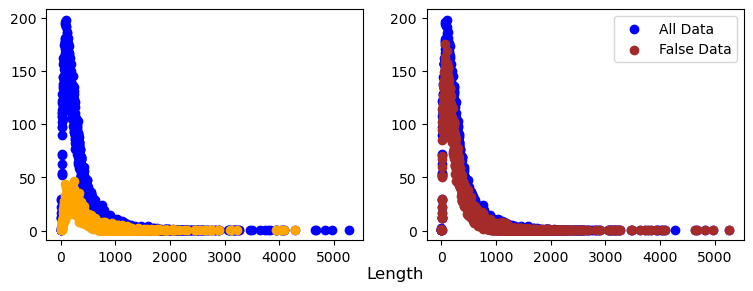

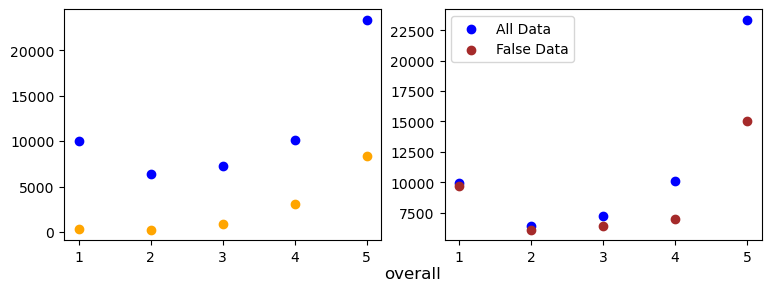

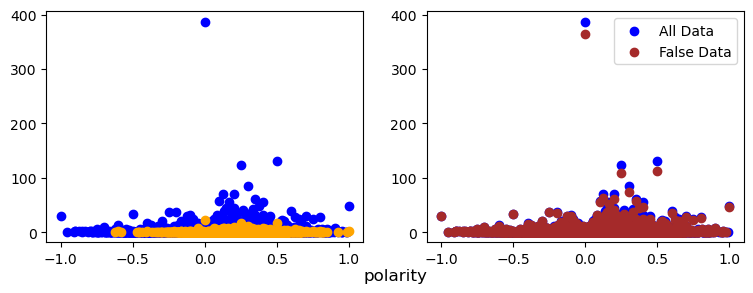

In [13]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_scatter_with_labels(data, title):
    plt.figure(figsize=(9, 3))
    plt.subplot(121)
    plt.scatter(data[0].keys(), data[0].values(), label = 'All Data', c = 'blue')
    plt.scatter(data[1].keys(), data[1].values(), label = 'True Data', c = 'orange')
    plt.subplot(122)
    plt.scatter(data[0].keys(), data[0].values(), label = 'All Data', c = 'blue')
    plt.scatter(data[2].keys(), data[2].values(), label = 'False Data', c = 'brown')
    plt.title(title, x=-0.1, y=-0.2)
    plt.legend()
    plt.show()

variables = ['Length', 'High/Low_Frequency_Ratio', 'Stopwords_Ratio', 'votes_all', 'overall', 'polarity']

for var in variables:
    all_data = Counter(train_df[var])
    true_data = Counter(train_df[train_df['label'] == 1][var])
    false_data = Counter(train_df[train_df['label'] == 0][var])

    plot_scatter_with_labels([all_data, true_data, false_data], var)


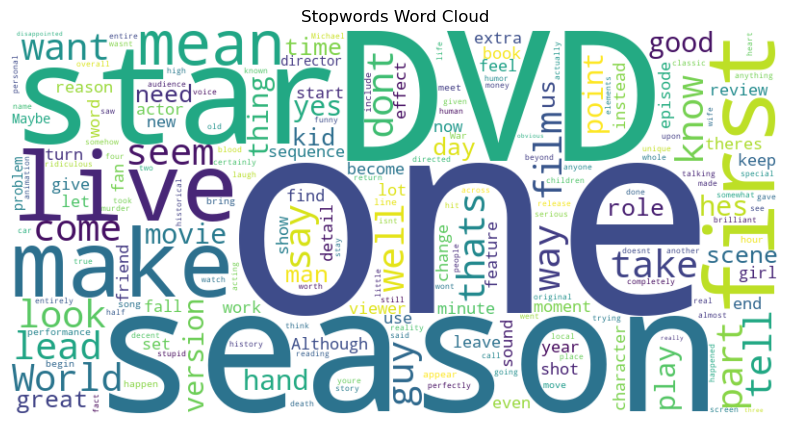

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# 统计词频
word_counts = Counter()

for text in train_df['reviewText']:
    words = text.split()
    word_counts.update(words)

common_words = dict(word_counts.most_common(len(stop_words)))  

stopwords_text = ' '.join(stop_words)

# 创建停用词词云
stopword_wordcloud = WordCloud(width=800, 
                               height=400, 
                               background_color='white').generate(stopwords_text)
# 创建高频词词云
common_wordcloud = WordCloud(width=800, 
                             height=400, 
                             background_color='white').generate_from_frequencies(common_words)

plt.figure(figsize=(10, 5))
plt.imshow(stopword_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Stopwords Word Cloud')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(common_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words Word Cloud')
plt.show()

### TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer


def vectorize(train_data, test_data=None, min_df=0.01, max_df=1.0, max_features=2000, stop_words='english', method='tf-idf'):
    vectorizer_args = {
        'min_df': min_df,
        'max_df': max_df,
        'max_features': max_features,
        'stop_words': stop_words,
        'ngram_range': (1, 1)
    }

    if method == 'count':
        vectorizer = CountVectorizer(**vectorizer_args)
    elif method == 'tf-idf':
        vectorizer = TfidfVectorizer(**vectorizer_args)

    features = vectorizer.fit_transform(train_data)
    names = vectorizer.get_feature_names_out()

    feature_lst = [features]

    if test_data is not None:
        features_test = vectorizer.transform(test_data)
        feature_lst.append(features_test)

    return names, feature_lst

names, feature_list = vectorize(train_df['reviewText'], test_df['reviewText'])
features, features_test = feature_list[0], feature_list[1]
print(features.shape, features_test.shape)

(57039, 1676) (11208, 1676)


In [16]:
def generate_stop_words(features, names, occ_thr=0.025, avg_thr=0.5):
    features_df = pd.DataFrame(features.toarray(), columns=names)
    
    # 分别提取正/负面评论的特征
    positive_features = features_df[train_df['label'] == 1]
    negative_features = features_df[train_df['label'] == 0]
    
    stop_words_to_add = []
    
    for name in names:
        # 提取正面和负面评论中包含该特征的样本
        positive_samples_with_feature = positive_features[positive_features[name] != 0]
        negative_samples_with_feature = negative_features[negative_features[name] != 0]
        
        # 计算特征在正面和负面评论中的占比差异
        occ_diff = abs(positive_samples_with_feature.shape[0]/positive_features.shape[0] - 
                       negative_samples_with_feature.shape[0]/negative_features.shape[0])
        
        # 计算特征在正面和负面评论中的出现率差异
        avg_diff = abs(positive_samples_with_feature[name].sum()/positive_samples_with_feature.shape[0] - 
                       negative_samples_with_feature[name].sum()/negative_samples_with_feature.shape[0])
        
        if occ_diff <= occ_thr and avg_diff <= avg_thr:
            stop_words_to_add.append(name)
    
    return stop_words_to_add

add_stop = generate_stop_words(features, names, occ_thr=0.25, avg_thr=0.5)

print(len(add_stop))

import nltk
from nltk.corpus import stopwords

stop_words = list(stopwords.words('english')) + add_stop

names, feature_list = vectorize(train_df['reviewText'], test_df['reviewText'], stop_words=stop_words)
features, features_test = feature_list[0], feature_list[1]
print(features.shape, features_test.shape)

1676
(57039, 136) (11208, 136)


### 划分训练集和验证集

使用train_df的数据划分为训练集和验证集,test_df作为测试集

![train_test_split](train_test_split.png)

In [18]:
def train_test_split(train_data, train_size = 0.8, test_size = 0.2, random_state=None, Shuffle=True):
    if Shuffle:
        train_data = train_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    split_idx = int(len(train_data) * train_size)
    train_set = train_data[:split_idx]
    cross_set = train_data[split_idx:]
    return train_set, cross_set

train_set, cross_set = train_test_split(train_df)
print(train_set.shape)
print(cross_set.shape)

(45631, 14)
(11408, 14)


In [34]:
from sklearn import preprocessing

test_Expected = pd.read_csv('groundTruth.csv')
new_test_Expected = pd.merge(test_df, test_Expected , on = 'Id', how = 'inner')

train_data = train_df[['Length', 'High/Low_Frequency_Ratio', 'Stopwords_Ratio', 'overall', 'polarity']]
X_train = np.hstack((features.toarray(), train_data))
X_train = preprocessing.MinMaxScaler().fit_transform(X_train)

test_data = new_test_Expected[['Length', 'High/Low_Frequency_Ratio', 'Stopwords_Ratio', 'overall', 'polarity']]

X_test = np.hstack((features_test.toarray(), test_data))
X_test = preprocessing.MinMaxScaler().fit_transform(X_test)

y_train = train_df['label']
y_test = new_test_Expected['Expected']

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(57039, 141)
(11208, 141)
(57039,)
(11208,)


### 基分类器

In [25]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


def predict_with_algorithms(X_train, y_train, X_test):
    # Linear SVM
    svm_classifier = SVC(kernel='linear')
    svm_classifier.fit(X_train, y_train)
    svm_predictions = svm_classifier.predict(X_train)
    accuracy_score_svm = accuracy_score(svm_predictions, y_train)
    print('svm_predictions :' , svm_predictions)
    print('accuracy_score_svm' , accuracy_score_svm)
    
    # Decision Tree
    tree_classifier = DecisionTreeClassifier()
    tree_classifier.fit(X_train, y_train)
    tree_predictions = tree_classifier.predict(X_train)
    accuracy_score_dt = accuracy_score(tree_predictions, y_train)
    print('tree_predictions :' , tree_predictions)
    print('accuracy_score_dt' , accuracy_score_dt)
    
    # Gaussian Naive Bayes
    gaussian_nb_classifier = GaussianNB()
    gaussian_nb_classifier.fit(X_train, y_train)
    gaussian_nb_predictions = gaussian_nb_classifier.predict(X_train)
    accuracy_score_gaussian_nb = accuracy_score(gaussian_nb_predictions, y_train)
    print('gaussian_nb_predictions :' , gaussian_nb_predictions)
    print('accuracy_score_gaussian_nb :' , accuracy_score_gaussian_nb)
    
    # Multinomial Naive Bayes
    multinomial_nb_classifier = MultinomialNB()
    multinomial_nb_classifier.fit(X_train, y_train)
    multinomial_nb_predictions = multinomial_nb_classifier.predict(X_train)
    accuracy_score_multinomial_nb = accuracy_score(multinomial_nb_predictions, y_train)
    print('multinomial_nb_predictions :' , multinomial_nb_predictions)
    print('accuracy_score_multinomial_nb :' , accuracy_score_multinomial_nb)
    
    # Bernoulli Naive Bayes
    bernoulli_nb_classifier = BernoulliNB()
    bernoulli_nb_classifier.fit(X_train, y_train)
    bernoulli_nb_predictions = bernoulli_nb_classifier.predict(X_train)
    accuracy_score_bernoulli_nb = accuracy_score(bernoulli_nb_predictions, y_train)
    print('bernoulli_nb_predictions :' , bernoulli_nb_predictions)
    print('accuracy_score_bernoulli_nb :' , accuracy_score_bernoulli_nb)   
    
    # K-Nearest Neighbors (k=2, 3, 5, 10)
    knn_2_classifier = KNeighborsClassifier(n_neighbors=2)
    knn_2_classifier.fit(X_train, y_train)
    knn_2_predictions = knn_2_classifier.predict(X_train)
    accuracy_score_knn_2 = accuracy_score(knn_2_predictions, y_train)
    print('knn_2_predictions :' , knn_2_predictions)
    print('accuracy_score_knn_2 :' , accuracy_score_knn_2)   
    
    knn_3_classifier = KNeighborsClassifier(n_neighbors=3)
    knn_3_classifier.fit(X_train, y_train)
    knn_3_predictions = knn_3_classifier.predict(X_train)
    accuracy_score_knn_3 = accuracy_score(knn_3_predictions, y_train)
    print('knn_3_predictions :' , knn_3_predictions)
    print('accuracy_score_knn_3 :' , accuracy_score_knn_3)  
    
    knn_5_classifier = KNeighborsClassifier(n_neighbors=5)
    knn_5_classifier.fit(X_train, y_train)
    knn_5_predictions = knn_5_classifier.predict(X_train)
    accuracy_score_knn_5 = accuracy_score(knn_5_predictions, y_train)
    print('knn_5_predictions :' , knn_5_predictions)
    print('accuracy_score_knn_5 :' , accuracy_score_knn_5)
    
    knn_10_classifier = KNeighborsClassifier(n_neighbors=10)
    knn_10_classifier.fit(X_train, y_train)
    knn_10_predictions = knn_10_classifier.predict(X_train)
    accuracy_score_knn_10 = accuracy_score(knn_10_predictions, y_train)
    print('knn_10_predictions :' , knn_10_predictions)
    print('accuracy_score_knn_10 :' , accuracy_score_knn_10)
    
    return (svm_predictions, tree_predictions, gaussian_nb_predictions, 
            multinomial_nb_predictions, bernoulli_nb_predictions, 
            knn_2_predictions, knn_3_predictions, knn_5_predictions, knn_10_predictions)


In [26]:
svm_predictions, tree_predictions, gaussian_nb_predictions, multinomial_nb_predictions, bernoulli_nb_predictions, knn_2_predictions, knn_3_predictions, knn_5_predictions, knn_10_predictions = predict_with_algorithms(X_train, y_train, X_test)

svm_predictions : [0 0 0 ... 0 0 0]
accuracy_score_svm 0.7738038885674714
tree_predictions : [0 0 1 ... 0 0 1]
accuracy_score_dt 1.0
gaussian_nb_predictions : [0 0 0 ... 0 1 0]
accuracy_score_gaussian_nb : 0.6507126702782307
multinomial_nb_predictions : [0 0 0 ... 0 0 0]
accuracy_score_multinomial_nb : 0.7738038885674714
bernoulli_nb_predictions : [1 1 0 ... 0 0 0]
accuracy_score_bernoulli_nb : 0.7022914146461193
knn_2_predictions : [0 0 0 ... 0 0 0]
accuracy_score_knn_2 : 0.8429670926909658
knn_3_predictions : [0 0 0 ... 0 0 0]
accuracy_score_knn_3 : 0.8487876715931205
knn_5_predictions : [0 0 0 ... 0 0 0]
accuracy_score_knn_5 : 0.8184049509984397
knn_10_predictions : [0 0 0 ... 0 0 0]
accuracy_score_knn_10 : 0.7905117551149213


可以看出knn算法准确率较高

### 集成学习算法

#### Bagging（Bootstrap Aggregating）

Bagging是一种基于并行策略的集成学习方法<br>
它的基本思想是通过随机采样（Bootstrap Sampling）的方式，从原始训练集中有放回地抽取多个样本子集，然后基于这些子集分别训练出多个基分类器<br>
最终的预测结果是通过对这些基分类器的投票（对分类任务）或者取平均（对回归任务）来得到的<br><br>

Bagging的优势在于可以降低模型的方差，因为各个子模型是独立训练的，可以并行处理<br>
常用的Bagging方法包括随机森林（Random Forest）<br>

##### Bagging + SVM

In [35]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification

def bagging_svm(X_train, y_train, num_models):
    models = []
    for _ in range(num_models):
        sample_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_subset = X_train[sample_indices]
        y_subset = y_train[sample_indices]
        
        svm_classifier = SVC(kernel='linear')
        svm_classifier.fit(X_subset, y_subset)
        models.append(svm_classifier)
    
    return models

def compute_auc(models, X_test, y_test):
    y_scores = np.zeros(len(y_test))
    for model in models:
        y_scores += model.decision_function(X_test)
    y_scores /= len(models)
    auc = roc_auc_score(y_test, y_scores)
    return auc

num_models = 5

models = bagging_svm(X_train, y_train, num_models)

auc = compute_auc(models, X_test, y_test)
print(f"AUC: {auc}")

AUC: 0.6440464100229216


##### Bagging + DecisionTree

AUC: 0.702377362552858


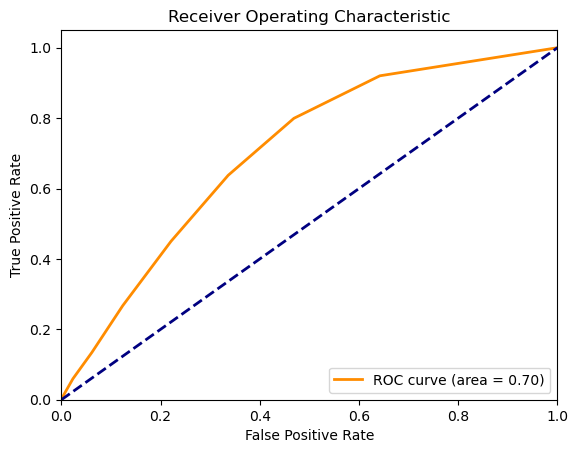

In [36]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def train_base_classifier(X, y, random_state=None):
    base_classifier = DecisionTreeClassifier(random_state=random_state)
    base_classifier.fit(X, y)
    return base_classifier

def bagging_ensemble(X, y, n_estimators, random_state=None):
    base_classifiers = []
    for i in range(n_estimators):
        sample_indices = np.random.choice(len(X), size=len(X), replace=True)
        X_sampled, y_sampled = X[sample_indices], y[sample_indices]
        
        base_classifier = train_base_classifier(X_sampled, y_sampled, random_state=random_state)
        base_classifiers.append(base_classifier)
    
    return base_classifiers

def predict_ensemble(X, base_classifiers):
    predictions = np.zeros((len(X), len(base_classifiers)))
    for i, base_classifier in enumerate(base_classifiers):
        predictions[:, i] = base_classifier.predict(X)
    return np.mean(predictions, axis=1)

# 训练 Bagging + Decisiontree 模型
n_estimators = 10
base_classifiers = bagging_ensemble(X_train, y_train, n_estimators, random_state=42)
y_pred = predict_ensemble(X_test, base_classifiers)

auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# 绘制 ROC 
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### AdaBoost.M1(Adaptive Boosting)

AdaBoost是一种基于序列学习的集成方法<br>
它的基本思想是通过对训练样本的加权，逐步地训练一系列的弱分类器，然后将它们线性组合成一个强分类器<br><br>

具体来说，AdaBoost会在每一轮训练中，根据前一轮分类器的性能，调整训练样本的权重，使得前一轮分类器分类错误的样本在下一轮训练中得到更多的关注<br>
最终的强分类器是通过将所有弱分类器的分类结果进行加权求和得到的<br><br>

AdaBoost的优势在于能够提高模型的准确率，尤其在处理复杂分类问题时表现良好

##### AdaBoost.M1 + SVM

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

base_classifier = SVC(kernel='linear', probability=True)

adaboost_classifier = AdaBoostClassifier(base_estimator=base_classifier, n_estimators=50, random_state=42)

adaboost_classifier.fit(X_train, y_train)

y_train_pred = adaboost_classifier.predict(X_train)
y_test_pred = adaboost_classifier.predict(X_test)

# 评估模型
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_roc_auc = roc_auc_score(y_train, adaboost_classifier.predict_proba(X_train)[:, 1])
test_roc_auc = roc_auc_score(y_test, adaboost_classifier.predict_proba(X_test)[:, 1])

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Test ROC AUC: {test_roc_auc}")

# 绘制 ROC
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, adaboost_classifier.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, adaboost_classifier.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='Test ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

D:\anaconda\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


##### AdaBoost.M1 + DecisionTree

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

np.random.seed(0)
X = np.random.rand(100, 2)
y = (X[:, 0] + X[:, 1] > 1).astype(int)

weights = np.ones(len(X)) / len(X)

weak_classifiers = []


num_iterations = 50

for t in range(num_iterations):
    weak_classifier = DecisionTreeClassifier(max_depth=1)
    weak_classifier.fit(X, y, sample_weight=weights)

    predictions = weak_classifier.predict(X)
    error_rate = np.sum(weights * (predictions != y)) / np.sum(weights)
    
    alpha = 0.5 * np.log((1 - error_rate) / error_rate)
    
    weights *= np.exp(-alpha * y * predictions)
    weights /= np.sum(weights)

    weak_classifiers.append((weak_classifier, alpha))

test_X = np.random.rand(100, 2)
test_y = (test_X[:, 0] + test_X[:, 1] > 1).astype(int)

final_predictions = np.zeros(len(test_X))
for classifier, alpha in weak_classifiers:
    final_predictions += alpha * classifier.predict(test_X)

auc = roc_auc_score(test_y, final_predictions)

print("AUC:", auc)

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.scatter(final_predictions, test_y)
plt.xlabel('Predicted Probabilities')
plt.ylabel('True Labels')
plt.title('ROC Curve')
plt.show()

In [ ]:
import csv
with open('./data/test_pre.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Id', 'Predicted'])
    for idx,row in enumerate(new_test_Expected):
        writer.writerow([idx, row])